# Motivation 
In this notebook we will load a trained model and use it to detect anomalies in the virtually synthesized anoumalous data. we will then build a heat map to visualize the auc score for different combinations of  anomaly frequency and anomaly amplitude.


In [52]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from config import settings
from psm.models.ad_systems import AD_system


In [2]:
# Load Settings and Initialize Paths
settings_proc = 'SETTINGS1'
settings_simu = 'SETTINGS1'
root = Path(settings.data.path["processed"])
database_path = (root / settings_simu / settings_simu.lower()).with_suffix('.db')
database_notch_path = (root / settings_simu / (settings_proc.lower() + "_vas")).with_suffix('.db')


In [3]:
root_raw = Path(settings.data.path["raw"])
resonance_avg_path = root_raw/ settings_simu / 'resonance_frequency.csv'
df_resonance_avg = pd.read_csv(resonance_avg_path)


In [4]:
df_resonance_avg

,system_id,res_freq_0,res_freq_1,res_freq_2,res_freq_3,res_freq_4,res_freq_5,res_freq_6,res_freq_7
0,0,125.098079,104.949172,99.628195,80.942865,61.873775,44.057350,21.375263,0.000084
1,1,120.458424,107.097433,97.417722,81.750525,62.774789,43.141425,20.846108,0.000083
2,10,123.688583,110.705530,101.432770,83.409186,64.421449,44.605311,21.602403,0.000086
3,11,123.768310,108.759546,103.355616,81.859865,65.312976,44.780443,22.169244,0.000086
4,12,122.239729,105.873252,99.369983,83.191515,63.628692,44.204555,21.501497,0.000085
5,13,120.908619,106.802706,97.454008,80.428157,62.965317,43.631210,21.481334,0.000084
6,14,128.828121,110.523914,101.509642,82.549468,64.909528,44.620312,21.664584,0.000086
7,15,123.650957,112.799599,101.234529,82.157115,65.288244,44.015592,21.846936,0.000086
8,16,126.173718,107.325475,99.186710,79.749262,65.199812,43.293355,21.577703,0.000085
9,17,122.664408,105.935996,100.977289,82.001955,63.672824,44.597041,21.759900,0.000085


In [5]:
# Fetch Metadata
from psm.utils.data.metadata import get_metadata_processed
metadata = get_metadata_processed(settings_proc, settings_simu)
freq_axis = metadata['freq']


In [6]:
# Model Loading Paths and Initialization
name_model_1 = 'best-epoch=28-val_loss=2.13.ckpt'
name_model_2 = 'best-epoch=95-val_loss=3.57.ckpt'
model_paths = Path(settings.data.path['model']) / 'model'
model_path_1 = model_paths / name_model_1
model_path_2 = model_paths / name_model_2

from psm.models.vanilla_classification import DenseSignalClassifierModule
model_1 = DenseSignalClassifierModule.load_from_checkpoint(model_path_1)
model_2 = DenseSignalClassifierModule.load_from_checkpoint(model_path_2)


In [7]:
# Anomaly Detection Setup
from psm.models.ad_systems import AD_GMM
ad_gmm_1 = AD_GMM(num_classes=20, model=model_1.model)
ad_gmm_2 = AD_GMM(num_classes=20, model=model_2.model)



In [8]:
# create the dataloader
from psm.models.prepare_data import CreateTransformer,PSDDataModule, PSDNotchDataset, PSDNotchDatasetOriginal

# create the transformer
transformer = CreateTransformer(database_path, freq=freq_axis, freq_min=0, freq_max=150)
transform_psd = transformer.transform_psd
transform_label = transformer.transform_label
dm = PSDDataModule(database_path, transform_psd, transform_label, batch_size=32)
dm.setup()
train_dl = dm.train_dataloader()
psd_notch = PSDNotchDataset(database_notch_path, transform=transform_psd, transform_label=transform_label)
psd_original = PSDNotchDatasetOriginal(database_notch_path,transform=transform_psd, transform_label=transform_label)

(anomaly_level=?) AND stage=? (0, 'train')
(anomaly_level=?) AND stage=? (0, 'test')
system_name LIKE ? ('%',)


In [ ]:
ad_gmm_1.fit(train_dl)
ad_gmm_2.fit(train_dl)

In [9]:
# investigate the model embedding
feature= []
target = []
for batch in train_dl:
    data, label = batch
    _,feat = model_1.model(data)
    feature.append(feat.detach().numpy())
    target.append(label.detach().numpy())
feature = np.concatenate(feature)

/tmp/ipykernel_29850/3970172679.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20')


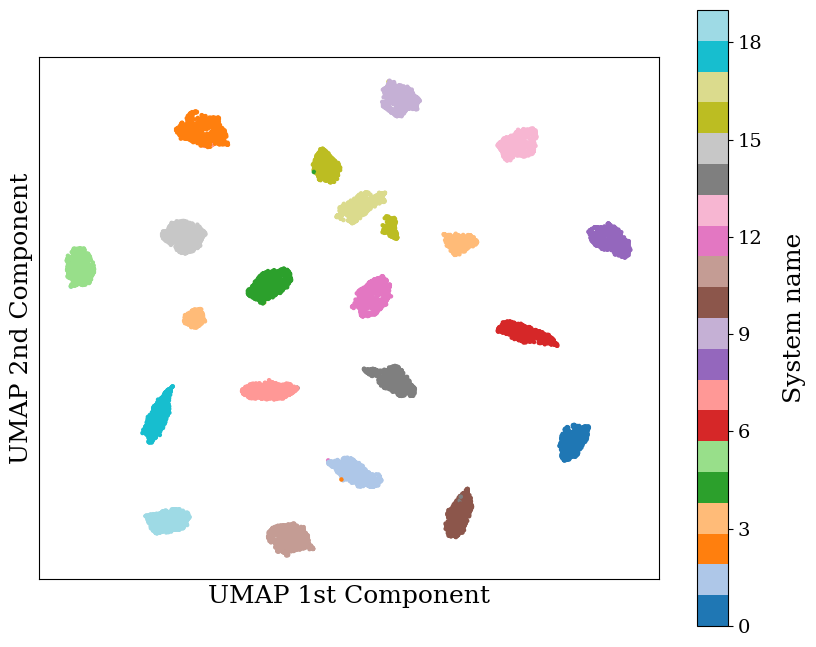

In [10]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(feature)

fig, ax = plt.subplots(figsize=(10, 8))  # Increase figure size

cmap = plt.cm.get_cmap('tab20')
sc = ax.scatter(embedding[:, 0], embedding[:, 1], c=target, cmap=cmap, s=5)  # Increase point size

cbar = plt.colorbar(sc, ax=ax, ticks=np.unique(target).astype(int)[::3])
cbar.set_label('System name', rotation=90, labelpad=15, fontsize=18)  # Increase fontsize

ax.set_xlabel('UMAP 1st Component', fontsize=18)  # Increase fontsize
ax.set_ylabel('UMAP 2nd Component', fontsize=18)  # Increase fontsize

ax.set_aspect('equal', 'box')

ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('embedding.png', dpi=300, bbox_inches='tight')
ax.set_yticks([])
ax.set_xticks([])
plt.show()


In [11]:
ad_gmm_1.fit(train_dl)
ad_gmm_2.fit(train_dl)

In [47]:
df_resonance_avg

,system_id,res_freq_0,res_freq_1,res_freq_2,res_freq_3,res_freq_4,res_freq_5,res_freq_6,res_freq_7
0,0,125.098,104.949,99.628,80.943,61.874,44.057,21.375,8.414e-05
1,1,120.458,107.097,97.418,81.751,62.775,43.141,20.846,8.331e-05
2,10,123.689,110.706,101.433,83.409,64.421,44.605,21.602,8.599e-05
3,11,123.768,108.760,103.356,81.860,65.313,44.780,22.169,8.645e-05
4,12,122.240,105.873,99.370,83.192,63.629,44.205,21.501,8.453e-05
5,13,120.909,106.803,97.454,80.428,62.965,43.631,21.481,8.396e-05
6,14,128.828,110.524,101.510,82.549,64.910,44.620,21.665,8.618e-05
7,15,123.651,112.800,101.235,82.157,65.288,44.016,21.847,8.603e-05
8,16,126.174,107.325,99.187,79.749,65.200,43.293,21.578,8.472e-05
9,17,122.664,105.936,100.977,82.002,63.673,44.597,21.760,8.492e-05


In [48]:
# let's clean the code for the benchmarking of the VAS
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from psm.eval.aucs_computation import compute_auc
from functools import partial
import seaborn as sns

def compute_anomaly_score(model,dataloaders):
    if not isinstance(dataloaders,list):
        raise ValueError('dataloaders should be a list of dataloaders')

    sys_names_list, f_notchs_list, amplitudes_list, log_likelihoods_list = [], [], [], []
    for dl in dataloaders:
        for psd,sys_name,amplitude_notch,f_affect in tqdm(dl,total=len(dl)):
            output = model.predict(psd)
            log_likelihoods_list.extend(output.tolist())
            sys_names_list.extend(sys_name.tolist())
            f_notchs_list.extend(f_affect.tolist())
            amplitudes_list.extend(amplitude_notch.tolist())
        
    df_res = pd.DataFrame({'system_name':sys_names_list,
                            'f_notch':f_notchs_list,
                            'amplitude':amplitudes_list,
                            'anomaly_index':log_likelihoods_list})
    return df_res
def add_auc_col(df_res,system_id=1):
    df_sys = df_res[df_res['system_name']==system_id]
    df_sys['anomaly_index'] = -df_sys['anomaly_index']
    df_healthy = df_sys[(df_sys['f_notch']==0) & (df_sys['amplitude']==0)]
    compute_auc_partial = partial(compute_auc,healthy=df_healthy['anomaly_index'].values)
    df_grouped = df_sys.groupby(['f_notch','amplitude'])['anomaly_index'].apply(compute_auc_partial)
    df_grouped=df_grouped.reset_index()
    df_grouped['AUC']=df_grouped['anomaly_index']
    return df_grouped        

def plot_heatmap(df_grouped, ax):
    # Prepare data for Heatmap
    heatmap_data = df_grouped.pivot(index='amplitude', columns='f_notch', values='AUC')

    # Plot heatmap
    cbar_kws = {'label': 'AUC', 'orientation': 'vertical'}
    sns.heatmap(heatmap_data, ax=ax, cmap='coolwarm', vmin=0.5, vmax=1, cbar_kws=cbar_kws)

    ax.set_xlabel('Frequency (f_notch)', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

    ax.invert_yaxis()


def plot_contour(df_grouped, ax, system_id=None, df_resonance_avg=None):
    # Prepare data for contour plot
    contour_data = df_grouped.pivot(index='amplitude', columns='f_notch', values='AUC')
    X = np.array(contour_data.columns)
    Y = np.array(contour_data.index)
    Z = contour_data.values
    contour_levels = [0.6, 0.7, 0.8, 0.9, 1.0]

    # Plot contour
    cp = ax.contour(X, Y, Z, cmap='viridis', levels=contour_levels)
    cbar = plt.colorbar(cp, ax=ax, orientation='vertical')
    cbar.set_label('AUC', fontsize=14)

    ax.set_xlabel('Frequency (f_notch)', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    if system_id:
        res_freq = df_resonance_avg[df_resonance_avg['system_id']==system_id].values.flatten()[1:]
        for fi in res_freq[1:-1]:
            ax.axvline(fi, color='black', linestyle='-.')
    ax.set_yticks([i/10 for i in range(-5,6)])
    ax.set_xticks([i for i in range(0,150,20)])


def compute_means(df_metrics):
    # remove 0 amplitude
    # check if AUC is column name
    if 'AUC' not in df_metrics.columns:
        raise ValueError('AUC should be a column name')
    
    df_auc = df_metrics[df_metrics['amplitude']!=0]['AUC'] # non 0 amplitude
    # compute the geometric mean
    geometric_mean = np.exp(np.mean(np.log(df_auc)))
    # compute the harmonic mean
    harmonic_mean = len(df_auc)/np.sum(1/df_auc)
    # compute the mean
    mean = np.mean(df_auc)
    return {'geometric_mean':geometric_mean, 'harmonic_mean':harmonic_mean, 'mean':mean}

def dict_diff(dict1, dict2):
    diff_dict = {}
    all_keys = set(dict1.keys()) | set(dict2.keys())

    for key in all_keys:
        val1 = dict1.get(key, "Key not in dict1")
        val2 = dict2.get(key, "Key not in dict2")

        if val1 != val2:
            diff_dict[key] = (val1- val2)
    
    return diff_dict


In [29]:
database_notch_path.exists()

True

In [37]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from psm.models.prepare_data import CreateTransformer,PSDDataModule, PSDNotchDataset, PSDNotchDatasetOriginal
psd_notch = PSDNotchDataset(database_notch_path, transform=transform_psd, transform_label=transform_label)
psd_original = PSDNotchDatasetOriginal(database_notch_path,transform=transform_psd, transform_label=transform_label)


system_name LIKE ? ('%',)


In [41]:
len(psd_notch)

11676000

In [43]:
from torch.utils.data import DataLoader
dl_psd_original = DataLoader(psd_original, batch_size=500000, shuffle=False)
dl_psd_notch = DataLoader(psd_notch, batch_size=700000, shuffle=False)

df_res1 = compute_anomaly_score(ad_gmm_1,[dl_psd_original,dl_psd_notch])
df_res2 = compute_anomaly_score(ad_gmm_2,[dl_psd_original,dl_psd_notch])

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 17/17 [10:21<00:00, 36.59s/it]


In [44]:
df_auc1 = add_auc_col(df_res1,system_id=1)
df_auc2 = add_auc_col(df_res2,system_id=1)

/tmp/ipykernel_29850/2741242932.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sys['anomaly_index'] = -df_sys['anomaly_index']
/tmp/ipykernel_29850/2741242932.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sys['anomaly_index'] = -df_sys['anomaly_index']


In [58]:

df_sys = df_res1[df_res1['system_name']==1]
df_sys.loc[:,'anomaly_index'] = -df_sys['anomaly_index']
df_sys.head()

,system_name,f_notch,amplitude,anomaly_index
1,1,0.0,0.0,-49.626
21,1,0.0,0.0,-48.571
41,1,0.0,0.0,-47.652
61,1,0.0,0.0,-48.331
81,1,0.0,0.0,-50.292


model 1
{'geometric_mean': 0.8856674431021277, 'harmonic_mean': 0.8624633879278228, 'mean': 0.9044109622302158}
model 2
{'geometric_mean': 0.8430503051256164, 'harmonic_mean': 0.8091081058507429, 'mean': 0.8714481474820145}


{'mean': 0.032962814748201286,
 'harmonic_mean': 0.05335528207707996,
 'geometric_mean': 0.04261713797651134}

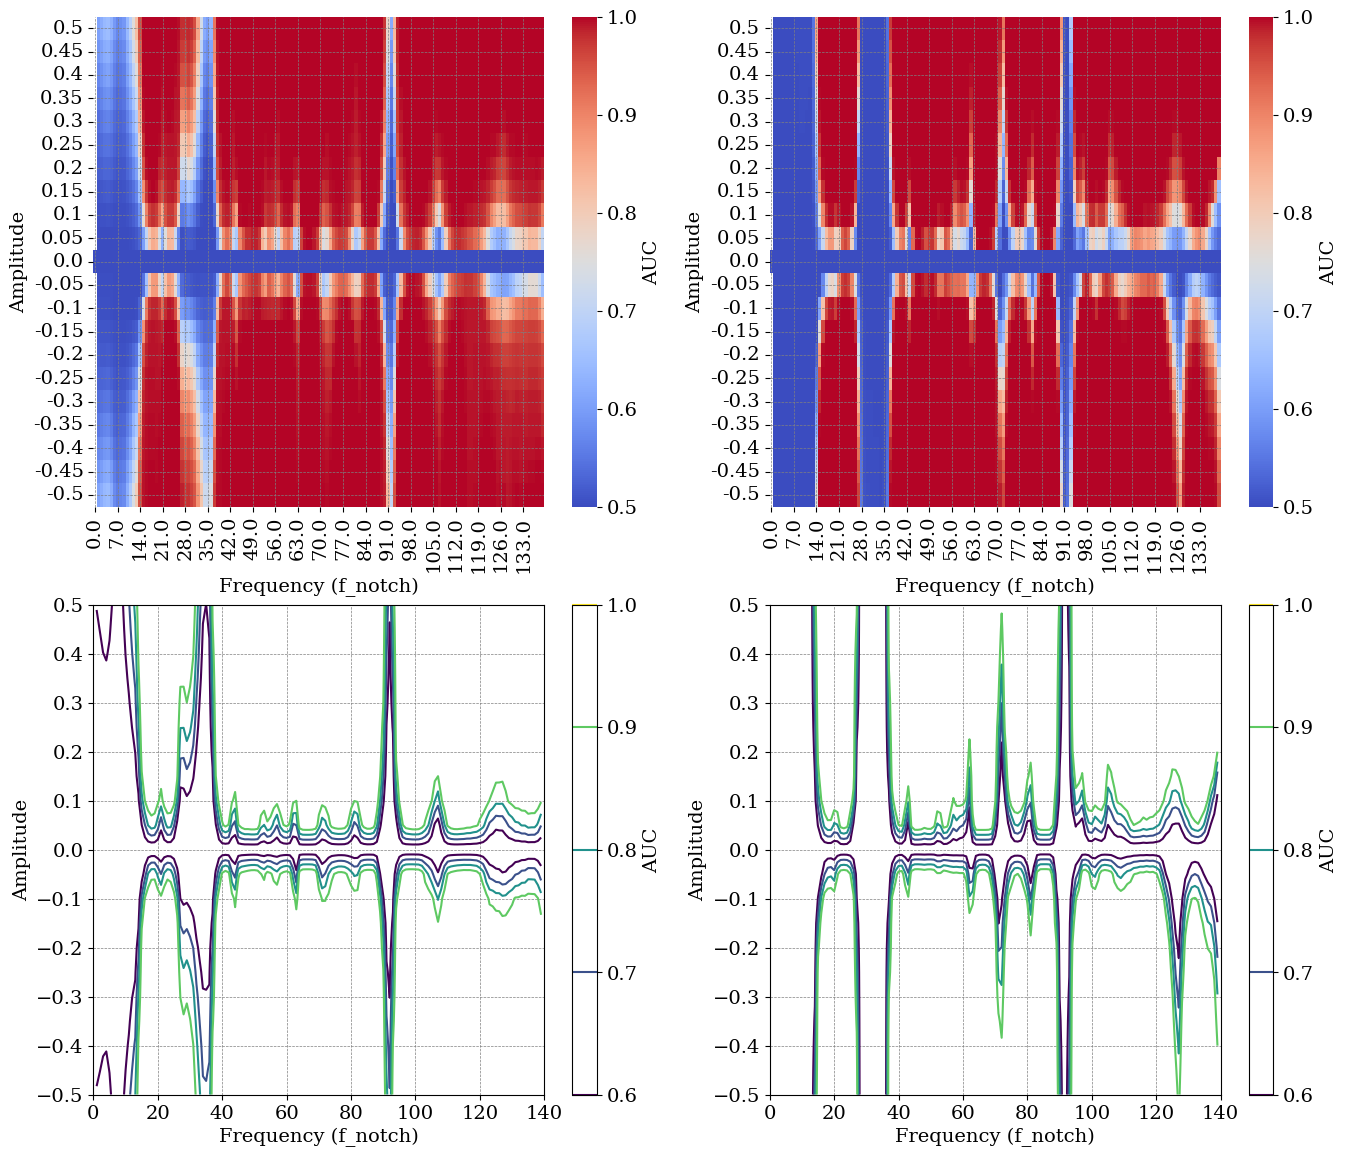

In [50]:
# plot the 2 heatmaps one next to the other and the 2 contour plots one next to the other
# using the function plot_heatmap and plot_contour
fig , ax = plt.subplots(ncols=2, nrows=2, figsize=(16, 14))
plot_heatmap(df_auc1,ax[0,0])
plot_heatmap(df_auc2,ax[0,1])
plot_contour(df_auc1,ax[1,0],system_id='system_1',df_resonance_avg=df_resonance_avg)
plot_contour(df_auc2,ax[1,1],system_id='system_1',df_resonance_avg=df_resonance_avg)
# print the means for the 2 models
print('model 1')
print(compute_means(df_auc1))
print('model 2')
print(compute_means(df_auc2))
dict_diff(compute_means(df_auc1), compute_means(df_auc2))

In [51]:
def compute_anomaly_score(model,dataloaders):
    if not isinstance(dataloaders,list):
        raise ValueError('dataloaders should be a list of dataloaders')

    sys_names_list, f_notchs_list, amplitudes_list, log_likelihoods_list = [], [], [], []
    for dl in dataloaders:
        for psd,sys_name,amplitude_notch,f_affect in tqdm(dl,total=len(dl)):
            output = model.predict(psd)
            log_likelihoods_list.extend(output.tolist())
            sys_names_list.extend(sys_name.tolist())
            f_notchs_list.extend(f_affect.tolist())
            amplitudes_list.extend(amplitude_notch.tolist())
        
    df_res = pd.DataFrame({'system_name':sys_names_list,
                            'f_notch':f_notchs_list,
                            'amplitude':amplitudes_list,
                            'anomaly_index':log_likelihoods_list})
    return df_res

def add_auc_col(df_res,system_id=1):
    df_sys = df_res[df_res['system_name']==system_id]
    df_sys['anomaly_index'] = -df_sys['anomaly_index']
    df_healthy = df_sys[(df_sys['f_notch']==0) & (df_sys['amplitude']==0)]
    compute_auc_partial = partial(compute_auc,healthy=df_healthy['anomaly_index'].values)
    df_grouped = df_sys.groupby(['f_notch','amplitude'])['anomaly_index'].apply(compute_auc_partial)
    df_grouped=df_grouped.reset_index()
    df_grouped['AUC']=df_grouped['anomaly_index']
    return df_grouped   

def compute_means(df_metrics):
    # remove 0 amplitude
    # check if AUC is column name
    if 'AUC' not in df_metrics.columns:
        raise ValueError('AUC should be a column name')
    
    df_auc = df_metrics[df_metrics['amplitude']!=0]['AUC'] # non 0 amplitude
    # compute the geometric mean
    geometric_mean = np.exp(np.mean(np.log(df_auc)))
    # compute the harmonic mean
    harmonic_mean = len(df_auc)/np.sum(1/df_auc)
    # compute the mean
    mean = np.mean(df_auc)
    return {'geometric_mean':geometric_mean, 'harmonic_mean':harmonic_mean, 'mean':mean}

def plot_heatmap(df_grouped, ax):
    # Prepare data for Heatmap
    heatmap_data = df_grouped.pivot(index='amplitude', columns='f_notch', values='AUC')

    # Plot heatmap
    cbar_kws = {'label': 'AUC', 'orientation': 'vertical'}
    sns.heatmap(heatmap_data, ax=ax, cmap='coolwarm', vmin=0.5, vmax=1, cbar_kws=cbar_kws)

    ax.set_xlabel('Frequency (f_notch)', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

    ax.invert_yaxis()


def plot_contour(df_grouped, ax, system_name=None, df_resonance_avg=None):
    # Prepare data for contour plot
    contour_data = df_grouped.pivot(index='amplitude', columns='f_notch', values='AUC')
    X = np.array(contour_data.columns)
    Y = np.array(contour_data.index)
    Z = contour_data.values
    contour_levels = [0.6, 0.7, 0.8, 0.9, 1.0]

    # Plot contour
    cp = ax.contour(X, Y, Z, cmap='viridis', levels=contour_levels)
    cbar = plt.colorbar(cp, ax=ax, orientation='vertical')
    cbar.set_label('AUC', fontsize=14)

    ax.set_xlabel('Frequency (f_notch)', fontsize=14)
    ax.set_ylabel('Amplitude', fontsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    if system_name:
        res_freq = df_resonance_avg[df_resonance_avg['name']==system_name].values.flatten()[1:]
        for fi in res_freq[1:-1]:
            ax.axvline(fi, color='black', linestyle='-.')
    ax.set_yticks([i/10 for i in range(-5,6)])
    ax.set_xticks([i for i in range(0,150,20)])


In [ ]:
# let's now build a class that does the benchmarking for us 
# and return the contour plot  and the harmonic mean 
# for tha given model , and all systems
from typing import Union, List, Dict, Tuple
from psm.models.ad_systems import AD_system
from dataclasses import dataclass

@dataclass
class Benchmark_VAS:
    """ Class for evaluating an anomaly detection system
    on virtually synthesized data. """
    anomaly_detector: AD_system
    notched_psd_dataloader: Union[DataLoader, List[DataLoader]]
    original_psd_dataloader: Union[DataLoader, List[DataLoader]]
    batch_size: int = None
    df_resonance_avg: pd.DataFrame = None
    
    def __post_init__(self):
        if not isinstance(self.notched_psd_dataloader, DataLoader):
            self.notched_psd_dataloader = DataLoader(self.notched_psd_dataloader, 
                                                batch_size=self.batch_size, shuffle=False)
            
        if not isinstance(self.original_psd_dataloader, DataLoader):
            self.original_psd_dataloader = DataLoader(self.original_psd_dataloader, 
                                                 batch_size=self.batch_size, shuffle=False)
        
        self.df_res = self.Compute_anomaly_score()
    
    def Compute_anomaly_score(self):
        df_res = compute_anomaly_score(self.anomaly_detector,
                              [self.original_psd_dataloader, self.notched_psd_dataloader])
        return df_res
    
    def Add_auc_col(self,df_res,system_id:int):
        df_metrics_sys = add_auc_col(df_res,system_id)
        return df_metrics_sys
    
    def Plot_contour(self,df_metrics_sys,ax,system_name:str):
        plot_contour(df_metrics_sys,ax,system_name,self.df_resonance_avg)
        return ax
    
    def Plot_heatmap(self,df_metrics_sys,ax):
        plot_heatmap(df_metrics_sys,ax)
        return ax
        
    
    def Compute_means(self,df_metrics_sys):
        optimization_metrics = compute_means(df_metrics_sys)
        return optimization_metrics
    
    
    def evaluate_one_individu(self,system_id:int):
        df_metrics_sys = self.Add_auc_col(self.df_res,system_id=system_id)
        optimization_metrics = self.Compute_means(df_metrics_sys)
        return optimization_metrics
    
    def evaluate_all_individus(self):
        id_list = [i for i in range(1,21)]

        optimization_metrics_list = {}
        for system_id in id_list:
            optimization_metrics = self.evaluate_one_individu(system_id)
            optimization_metrics_list[f'system_{system_id}'] = optimization_metrics
        return optimization_metrics_list
    
    def plot_all_systems(self):
        id_list= [i for i in range(1,21)]
        figures = {}
        for system_id in id_list:
            fig,ax= plt.subplots(figisize=(10,8))
            df_metrics_sys = self.Add_auc_col(self.df_res,system_id=system_id)
            self.Plot_contour(df_metrics_sys,ax,system_name='system_'+str(system_id))
            figures['system_'+str(system_id)] = fig
        return figures

In [ ]:
bench_vas = Benchmark_VAS(ad_gmm_1, psd_notch, psd_original, batch_size=500000, df_resonance_avg=df_resonance_avg)
res = bench_vas.evaluate_all_individus()

100%|██████████| 24/24 [07:38<00:00, 19.10s/it]
/tmp/ipykernel_121636/1145642243.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sys['anomaly_index'] = -df_sys['anomaly_index']
/tmp/ipykernel_121636/1145642243.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sys['anomaly_index'] = -df_sys['anomaly_index']
/tmp/ipykernel_121636/1145642243.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [53]:
df_res

NameError: name 'df_res' is not defined